In [205]:
!pip install graphviz
!pip install transformers
!pip install bert
!pip install bert-tensorflow
!pip install keras
!pip install dask_ml
!pip install xgboost

     |████████████████████████████████| 157.5 MB 22 kB/s /s eta 0:00:01


In [1]:
# Import relevent packages
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle

# Import dask packages
import dask.dataframe as ddf
from math import nan
import panel as pn
import dask
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
import seaborn as sns
import matplotlib.pyplot as plt
from dask_ml.model_selection import train_test_split
import graphviz
from datascroller import scroll

from dask.diagnostics import ProgressBar
ProgressBar().register()

# text processing libraries
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
# from sklearn.model_selection import train_test_split

import json
import os
import sys
import tensorflow as tf

import transformers as ppb
from time import time
import io
import re
from csv import reader

import bert
# from bert import run_classifier
# from bert import optimization
from bert import tokenization
from transformers import RobertaTokenizer, TFRobertaModel

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow import keras
#### if use tensorflow=2.0.0, then import tensorflow.keras.model_selection 
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier



from datetime import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Install BERT and BERT Tokenizer from the HuggingFace Transformers library.

We can easily switch between variants of BERT by changing out which model we import from HuggingFace; the rest of the code just flows unchanged.

In [2]:
# For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.TFDistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.TFBertModel, ppb.BertTokenizer, 'bert-base-uncased')

## For BERT Large, use this:
# model_class, tokenizer_class, pretrained_weights = (ppb.AutoModelWithLMHead, ppb.AutoTokenizer, 'bert-large-uncased')
# from transformers import AutoTokenizer, AutoModelWithLMHead

# For ROBERTa base model, use this:
# model_class, tokenizer_class, pretrained_weights = (ppb.TFRobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Let's do an initial import on the sample dataset Padma created for HS4 codes 8712 and 8714

In [3]:
!ls /data/common/trade_data

 2019
 2019_updated
 HS
 enigma
 import_data_2017_enhanced.parq
 import_data_2018_enhanced.parq
 import_data_2019_enhanced.parq
 import_data_2020_enhanced.parq
 linux-bsd.gif
'manifestDB - CMDT Codes directory.xlsx'
'manifestDB - Data Fields Description.xlsx'
'manifestDB - Main Coverage Ports Directory.xlsx'
'manifestDB - Packing Unit Description.xlsx'
 raw_import_20152016.parq
 raw_import_2017.parq
 raw_import_2018.parq
 raw_import_2019.parq
 raw_import_2020.parq
 us_customs_aug2019.parq
 w210_raw_data.ipynb


In [4]:
import_df = dd.read_parquet('/data/common/trade_data/2019/data_samples/sample_87128714.parq', engine='fastparquet', chunksize="100MB")

In [77]:
import_df.columns

Index(['System Identity Id', 'Estimate Arrival Date', 'Actual Arrival Date',
       'Bill of Lading', 'Master Bill of Lading', 'Bill Type Code',
       'Carrier SASC Code', 'Vessel Country Code', 'Vessel Code',
       'Vessel Name', 'Voyage', 'Inbond Type', 'Manifest No',
       'Mode of Transportation', 'Loading Port', 'Last Vist Foreign Port',
       'US Clearing District', 'Unloading Port', 'Place of Receipt', 'Country',
       'Country Sure Level', 'Weight in KG', 'Weight', 'Weight Unit', 'TEU',
       'Quantity', 'Quantity Unit', 'Measure in CM', 'Measure', 'Measure Unit',
       'Container Id', 'Container Size', 'Container Type',
       'Container Desc Code', 'Container Load Status',
       'Container Type of Service', 'Shipper Name', 'Shipper Address ',
       'Raw Shipper Name', 'Raw Shipper Addr1', 'Raw Shipper Addr2',
       'Raw Shipper Addr3', 'Raw Shipper Addr4', 'Raw Shipper Addr Others',
       'Consignee Name', 'Consignee Address ', 'Raw Consignee Name',
       'Raw Con

In [80]:
# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", -1)

import_df.head(2)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s


,System Identity Id,Estimate Arrival Date,Actual Arrival Date,Bill of Lading,Master Bill of Lading,Bill Type Code,Carrier SASC Code,Vessel Country Code,Vessel Code,Vessel Name,...,Product Desc,Marks & Numbers,HS Code Sure Level,CIF,Indicator of true supplier,Indicator of true buyer,END,HS Code,HS_Code,Merged_Description
0,6003201907090000254809,20190705,20190705,CHSLTPE19060165,EGLV003901609611,H,"CHSL, CHISLEY MOTOR COACHES",PA,9306990,OOCL VANCOUVER,...,"ELLIPTICAL TRAINER,TREADMILL, ESCALATE<br/>",NO MARKS<br/>,5,0.0,Y,Y,END,871200,871200,"Bicycles and other cycles (including delivery tricycles), not motorized ;Bicycles having both wheels not exceeding 63.5 cm in diameter;Having both wheels not exceeding 50 cm in diameter;Having both wheels exceeding 50 cm but not exceeding 55 cm in diameter;Having both wheels exceeding 55 cm but not exceeding 63.5 cm in diameter;If weighing less than 16.3 kg complete without accessories and not designed for use with tires having a cross-sectional diameter exceeding 4.13 cm;Bicycles having both wheels exceeding 63.5 cm in diameter ;Other;Bicycles having a front wheel exceeding 55 cm but not exceeding 63.5 cm in diameter and a rear wheel exceeding 63.5 cm in diameter, weighing less than 16.3 kg complete without accessories and not designed for use with tires having a cross-sectional diameter exceeding 4.13 cm, valued $200 or more each;Other bicycles;Other cycles"
1,6003201901040000381477,20181230,20190103,AMAWSHNGBA807064,APLUNPFB000624,H,AMAW,CN,APL BARCELONA,APL BARCELONA,...,SCH 830 TREADMILL<br/>,AS ADDRESSED<br/>,5,0.0,Y,Y,END,871200,871200,"Bicycles and other cycles (including delivery tricycles), not motorized ;Bicycles having both wheels not exceeding 63.5 cm in diameter;Having both wheels not exceeding 50 cm in diameter;Having both wheels exceeding 50 cm but not exceeding 55 cm in diameter;Having both wheels exceeding 55 cm but not exceeding 63.5 cm in diameter;If weighing less than 16.3 kg complete without accessories and not designed for use with tires having a cross-sectional diameter exceeding 4.13 cm;Bicycles having both wheels exceeding 63.5 cm in diameter ;Other;Bicycles having a front wheel exceeding 55 cm but not exceeding 63.5 cm in diameter and a rear wheel exceeding 63.5 cm in diameter, weighing less than 16.3 kg complete without accessories and not designed for use with tires having a cross-sectional diameter exceeding 4.13 cm, valued $200 or more each;Other bicycles;Other cycles"


In [6]:
len(import_df.index)

[########################################] | 100% Completed |  0.1s


7269

In [9]:
df1 = import_df[['Product Desc', 'HS_Code']]
df1.columns = ['Desc', 'HSCode']
print(df1.head(2))
print(len(df1))

[########################################] | 100% Completed |  0.1s
                                          Desc  HSCode
0  ELLIPTICAL TRAINER,TREADMILL, ESCALATE<br/>  871200
1                       SCH 830 TREADMILL<br/>  871200
[########################################] | 100% Completed |  0.1s
7269


In [10]:
hs_code_desc = import_df[['HS_Code', 'Merged_Description']]
hs_code_desc = hs_code_desc.drop_duplicates()
hs_code_desc.columns = ['HSCode', 'Desc']
print(hs_code_desc.head(2))
print(len(hs_code_desc))

[########################################] | 100% Completed |  0.1s
      HSCode                                               Desc
0     871200  Bicycles and other cycles (including delivery ...
1000  871410  Parts and accessories of vehicles of headings ...
[########################################] | 100% Completed |  0.1s
10


In [11]:
df1 = df1.append(hs_code_desc[['Desc', 'HSCode']]).reset_index()
len(df1)

[########################################] | 100% Completed |  0.1s


7279

In [12]:
# convert the dataframes back to pandas

df1_pd = df1.compute()
len(df1_pd)

[########################################] | 100% Completed |  0.1s


7279

In [13]:
df1_pd['Desc'] = [re.sub('\d{4,}', '', x) for x in df1_pd['Desc']]

### Let's tokenize the description fields.

#### Create embeddings with nltk

In [14]:
def tokenize(data, column_name):
    '''
    Tokenize text
    '''
    tokens = data[column_name].apply((lambda x: nltk.word_tokenize(x)))
    
    data['NLTK'+column_name] = np.array(tokens)
    
    return data
#     return list(
#         filter(lambda word: word.isalnum(), tokens)
#     )

stop_words = stopwords.words("english")

def remove_stopwords(words):
    '''
    Remove stop words from the list of words
    '''
    
    filtered = filter(lambda word: word not in stop_words, words)
    
    return list(filtered)

#### Create embeddings with BERT

In [15]:
def pre_process(data, column_name, max_length):
    """
    Function takes inputs:
    - data in the form of a pandas dataframe
    - column_name containing the text to be embedded
    - max length
    and produces as output the input data BERT requires as an array consisting of:
    - Sentence IDs padded to the max length
    - BERT Masks that tell BERT which of the Sentence IDs are 0 and should be ignored
    - SequenceIDs which are all 0 for our classification task
    """
    # Tokenize each item and add the special beginning/end tokens
    tokenized = data[column_name].apply((lambda x: tokenizer.encode(x, add_special_tokens=False, max_length=max_length, truncation=True)))
    data['BERT_'+column_name] = np.array(tokenized)
#     data['BERT_'+column_name] = tokenized
      
#     # Create the padding based on the max length so all are same shape
#     bertSentenceIDs = np.array([i + [0]*(max_length-len(i)) for i in tokenized.values])
    
#     # Create the attention mask so BERT knows which contain values and which are 0s that should be ignored
#     bertMasks = np.where(bertSentenceIDs != 0, 1, 0)

#     # Create the BERT sequence IDs. In this case they are all 0 since it's the same sentence input.
#     bertSequenceIDs = np.array([np.zeros(max_length) for i in tokenized.values], dtype=int)
    
#     # Create and return the data array containing both the padded and the attention mask
#     X_data = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

#     # Also look at the vocabulary size in the tokenizer

    return data

In the past we have run into memory issues depending on the length of the input, so we set up a variable to truncate the tokens being input for each record.

First, let's check the max length of the different tokenized columns of interest.

In [16]:
length_lst = ['Product Desc', 'Merged_Description']

max_length_dict = {}

for l in length_lst:
    tokenized = []
    tokenized = import_df_pd[l].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    # Find the max length for the tokenized examples
    max_length = 0
    for i in tokenized.values:
        if len(i) > max_length:
            max_length = len(i)
            

    print('Max length of column', l, max_length)

NameError: name 'import_df_pd' is not defined

This could be a problem if we have very, very short entries in the description fields.

Some possible solutions:
1. Augment each entry with the dictionary definition.
2. Add extra training records of just the dictionary definition.
3. Train on only the dictionary definition.

### Encode the description fields.

In [17]:
max_length = 180

# Create BERT embeddings for Product Desc and Merged_Description, append to pandas dataframe
X_pd = pre_process(df1_pd, 'Desc', max_length)



# Create NLTK embeddings for Product Desc and Merged_Description, append to pandas dataframe
X_pd = tokenize(X_pd, 'Desc')

X_pd.head()



,index,Desc,HSCode,BERT_Desc,NLTKDesc
0,0,"ELLIPTICAL TRAINER,TREADMILL, ESCALATE<br/>",871200,"[27213, 10365, 1010, 29449, 19912, 1010, 9686,...","[ELLIPTICAL, TRAINER, ,, TREADMILL, ,, ESCALAT..."
1,1,SCH 830 TREADMILL<br/>,871200,"[8040, 2232, 6640, 2692, 29449, 19912, 1026, 7...","[SCH, 830, TREADMILL, <, br/, >]"
2,2,FITNESSMACHINE; TREADMILL<br/>,871200,"[10516, 22911, 14014, 1025, 29449, 19912, 1026...","[FITNESSMACHINE, ;, TREADMILL, <, br/, >]"
3,3,COMPLETE BICYCLES & BICYCLE PARTS & ELECTRIC B...,871200,"[3143, 21066, 1004, 10165, 3033, 1004, 3751, 1...","[COMPLETE, BICYCLES, &, BICYCLE, PARTS, &, ELE..."
4,4,LOUISIANA GRILLS LG900 W FRONT SHELF<br/>,871200,"[5773, 18651, 2015, 1048, 2290, 21057, 2692, 1...","[LOUISIANA, GRILLS, LG900, W, FRONT, SHELF, <,..."


### Create train, dev, and test sets

In [18]:
y_pd = X_pd['HSCode']

# Split once to create the test set
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=91)

# Re-split the train set to create a dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=91)

print('Size of the train set is', len(X_train))
print('Size of the dev set is', len(X_dev))
print('Size of the test set is', len(X_test))
print('Size of the train label set is', len(y_train))
print('Size of the dev label set is', len(y_dev))
print('Size of the test label set is', len(y_test))


Size of the train set is 4658
Size of the dev set is 1165
Size of the test set is 1456
Size of the train label set is 4658
Size of the dev label set is 1165
Size of the test label set is 1456


In [19]:
# def encode_labels(Y):
#     """
#     Function that takes in a np.array of string categorical labels and returns a one-hot encoded transformation.
#     """
#     # encode class values as integers
#     encoder = LabelEncoder()
#     encoder.fit(Y)
#     encoded_Y = encoder.transform(Y)
#     # convert integers to dummy variables (i.e. one hot encoded)
#     return np_utils.to_categorical(encoded_Y)


## Create baseline of predicting the majority class

In [20]:
counts = X_train['HSCode'].value_counts().to_dict()
# print(counts)
max_value = max(counts.values())
print('Accuracy when predicting majority class ', max_value/len(X_train))

Accuracy when predicting majority class  0.14104765993988835


## Construct a Naive Bayes model

### Use BOW on the words in the Product Desc column

In [21]:
count_vector = CountVectorizer()

# fit_transform() creates dictionary and return term-document matrix.
X_train_counts = count_vector.fit_transform(X_train['Desc'])


In [93]:
clf1 = MultinomialNB().fit(X_train_counts, y_train)

In [94]:
X_new_counts = count_vector.transform(X_dev['Desc'])
# X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Execute prediction(classification).
predicted = clf1.predict(X_new_counts)

In [95]:
print('F1 score:', f1_score(y_dev, predicted, average="macro"))
print('Precision:', precision_score(y_dev, predicted, average="macro"))
print('Recall:', recall_score(y_dev, predicted, average="macro")) 

F1 score: 0.7569916664560667
Precision: 0.8839297983486407
Recall: 0.7399406035021568


<Figure size 2160x2160 with 0 Axes>

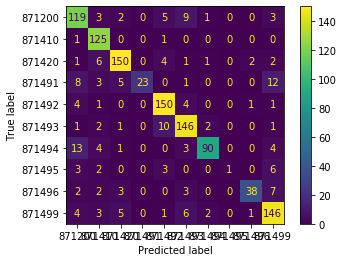

In [96]:
plt.figure(figsize=(30,30))
plot_confusion_matrix(clf1, X_new_counts, y_dev)

plt.show()

### Use TF-IDF on the words in the Product Desc column

In [97]:

count_vector = CountVectorizer()

# fit_transform() creates dictionary and return term-document matrix.
X_train_counts = count_vector.fit_transform(X_train['Desc'])

# Import TfidfTransformer class.
# TfidfTransformer transoforms count matrix to tf-idf representation.

tfidf_transformer = TfidfTransformer()

# fit_transform transforms count matrix to tf-idf representation(vector).
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [98]:
# Create model(naive bayes) and training. 

clf2 = MultinomialNB().fit(X_train_tfidf, y_train)

In [99]:
# Create predictions
# Transfroming.
X_new_counts = count_vector.transform(X_dev['Desc'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Execute prediction(classification).
predicted = clf2.predict(X_new_tfidf)

In [100]:
print('F1 score:', f1_score(y_dev, predicted, average="macro"))
print('Precision:', precision_score(y_dev, predicted, average="macro"))
print('Recall:', recall_score(y_dev, predicted, average="macro")) 

F1 score: 0.7136357770555559
Precision: 0.7807965265485755
Recall: 0.7001330742007502


In [101]:
cm = confusion_matrix(y_dev, predicted)
cm

array([[122,   3,   2,   0,   3,   9,   1,   0,   0,   2],
       [  2, 121,   0,   0,   0,   3,   0,   0,   0,   1],
       [  1,   6, 148,   0,   4,   2,   2,   0,   0,   4],
       [ 10,   3,   7,  17,   1,   3,   0,   0,   0,  11],
       [  6,   0,   0,   0, 145,  10,   0,   0,   0,   0],
       [  3,   1,   1,   0,   7, 149,   2,   0,   0,   0],
       [ 13,   4,   1,   0,   1,   5,  88,   0,   0,   3],
       [  4,   2,   0,   0,   2,   0,   0,   0,   0,   7],
       [  3,   2,   5,   0,   2,   3,   1,   0,  29,  10],
       [  5,   1,   6,   0,   1,   8,   1,   0,   0, 146]])

<Figure size 2160x2160 with 0 Axes>

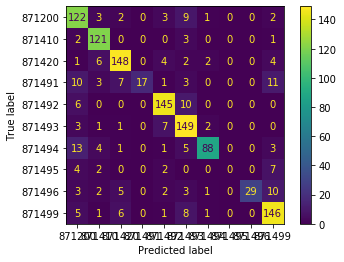

In [102]:
# Plot non-normalized confusion matrix


plt.figure(figsize=(30,30))
plot_confusion_matrix(clf2, X_new_tfidf, y_dev)

plt.show()

### Use BOW on the Merged Description field

In [123]:
# fit_transform() creates dictionary and return term-document matrix.
X_train_counts = count_vector.fit_transform(X_train['Merged_Description'])

# # Import TfidfTransformer class.
# # TfidfTransformer transoforms count matrix to tf-idf representation.
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()

# # fit_transform transforms count matrix to tf-idf representation(vector).
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [124]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf3 = MultinomialNB().fit(X_train_counts, y_train)

In [125]:
# Create predictions
# Transfroming.
X_new_counts = count_vector.transform(X_dev['Merged_Description'])
# X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Execute prediction(classification).
predicted = clf3.predict(X_new_counts)

In [126]:
print('F1 score:', f1_score(y_dev, predicted, average="macro"))
print('Precision:', precision_score(y_dev, predicted, average="macro"))
print('Recall:', recall_score(y_dev, predicted, average="macro")) 

F1 score: 0.8969924812030076
Precision: 0.8941605839416059
Recall: 0.9


<Figure size 2160x2160 with 0 Axes>

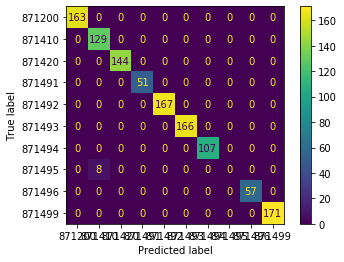

In [128]:
# Plot non-normalized confusion matrix
from sklearn.metrics import plot_confusion_matrix

plt.figure(figsize=(30,30))
plot_confusion_matrix(clf3, X_new_counts, y_dev)

plt.show()

### Use TF-IDF on the Merged Description field

In [103]:
# fit_transform() creates dictionary and return term-document matrix.
X_train_counts = count_vector.fit_transform(X_train['Merged_Description'])

# Import TfidfTransformer class.
# TfidfTransformer transoforms count matrix to tf-idf representation.
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_transform transforms count matrix to tf-idf representation(vector).
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [104]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf2 = MultinomialNB().fit(X_train_tfidf, y_train)

In [105]:
# Create predictions
# Transfroming.
X_new_counts = count_vector.transform(X_dev['Merged_Description'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Execute prediction(classification).
predicted = clf2.predict(X_new_tfidf)

In [106]:
print('F1 score:', f1_score(y_dev, predicted, average="macro"))
print('Precision:', precision_score(y_dev, predicted, average="macro"))
print('Recall:', recall_score(y_dev, predicted, average="macro")) 

F1 score: 0.8969924812030076
Precision: 0.8941605839416059
Recall: 0.9


<Figure size 2160x2160 with 0 Axes>

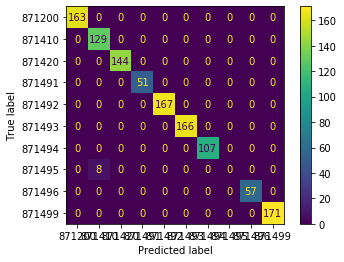

In [107]:
# Plot non-normalized confusion matrix
from sklearn.metrics import plot_confusion_matrix

plt.figure(figsize=(30,30))
plot_confusion_matrix(clf2, X_new_tfidf, y_dev)

plt.show()

In [108]:
cm = confusion_matrix(y_dev, predicted)
cm

array([[163,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 129,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 144,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  51,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 167,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 166,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 107,   0,   0,   0],
       [  0,   8,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  57,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 171]])

### Use the BERT embeddings in the Product Desc column

In [81]:
# Convert the embedding column from list to string
X_train['BERTProduct Desc'] = X_train['BERTProduct Desc'].apply(str).apply(', '.join)
X_train.head()

,Product Desc,Merged_Description,HS_Code,BERTProduct Desc,BERTMerged_Description,NLTKProduct Desc,NLTKMerged_Description
4568,GEAR REAR PTO IDLER GEAR HUB<br/>,"Parts and accessories of vehicles of headings 8711 to 8713 ;Other ;Hubs, other than coaster braking hubs and hub brakes, and free-wheel sprocket-wheels ;Aluminum alloy hubs with a hollow axle and lever-operated quick release mechanism;Hubs ;Three speed;Variable speed (except three speed) with internal gear changing mechanisms ;Two speed;Other;Free-wheel sprocket-wheels;Multiple free-wheel sprockets",871493,"[, 6, 7, 1, 8, ,, , 4, 3, 7, 3, ,, , 1, 3, 8, 6, 6, ,, , 2, 0, 8, 0, ,, , 1, 8, 3, 7, 3, ,, , 2, 0, 9, 9, ,, , 6, 7, 1, 8, ,, , 9, 5, 9, 4, ,, , 1, 0, 2, 6, ,, , 7, 9, 8, 7, ,, , 1, 0, 1, 3, ,, , 1, 0, 2, 8, ]","[3033, 1998, 16611, 1997, 4683, 1997, 5825, 2015, 6584, 14526, 2000, 6584, 17134, 1025, 2060, 1025, 9594, 2015, 1010, 2060, 2084, 16817, 24427, 9594, 2015, 1998, 9594, 13627, 1010, 1998, 2489, 1011, 5217, 11867, 16901, 3388, 1011, 7787, 1025, 13061, 17564, 9594, 2015, 2007, 1037, 8892, 17290, 1998, 15929, 1011, 3498, 4248, 2713, 7337, 1025, 9594, 2015, 1025, 2093, 3177, 1025, 8023, 3177, 1006, 3272, 2093, 3177, 1007, 2007, 4722, 6718, 5278, 10595, 1025, 2048, 3177, 1025, 2060, 1025, 2489, 1011, 5217, 11867, 16901, 3388, 1011, 7787, 1025, 3674, 2489, 1011, 5217, 11867, 16901, 8454]","[GEAR, REAR, PTO, IDLER, GEAR, HUB, <, br/, >]","[Parts, and, accessories, of, vehicles, of, headings, 8711, to, 8713, ;, Other, ;, Hubs, ,, other, than, coaster, braking, hubs, and, hub, brakes, ,, and, free-wheel, sprocket-wheels, ;, Aluminum, alloy, hubs, with, a, hollow, axle, and, lever-operated, quick, release, mechanism, ;, Hubs, ;, Three, speed, ;, Variable, speed, (, except, three, speed, ), with, internal, gear, changing, mechanisms, ;, Two, speed, ;, Other, ;, Free-wheel, sprocket-wheels, ;, Multiple, free-wheel, sprockets]"
1585,NEW MOTORCYCLE EXHAUST PARTS HS CODE:871410 24 CAR,Parts and accessories of vehicles of headings 8711 to 8713 ;Of motorcycles (including mopeds);Saddles and seats;Wheels;Other,871410,"[, 2, 0, 4, 7, ,, , 9, 0, 5, 5, ,, , 1, 5, 0, 9, 5, ,, , 3, 0, 3, 3, ,, , 2, 6, 2, 3, 6, ,, , 3, 6, 4, 2, ,, , 1, 0, 2, 4, ,, , 6, 5, 8, 4, ,, , 1, 6, 9, 3, 2, ,, , 1, 0, 7, 9, 0, ,, , 2, 4, 8, 4, ,, , 2, 4, 8, 2, ]","[3033, 1998, 16611, 1997, 4683, 1997, 5825, 2015, 6584, 14526, 2000, 6584, 17134, 1025, 1997, 18580, 1006, 2164, 9587, 5669, 2015, 1007, 1025, 12279, 2015, 1998, 4272, 1025, 7787, 1025, 2060]","[NEW, MOTORCYCLE, EXHAUST, PARTS, HS, CODE:871410, 24, CAR]","[Parts, and, accessories, of, vehicles, of, headings, 8711, to, 8713, ;, Of, motorcycles, (, including, mopeds, ), ;, Saddles, and, seats, ;, Wheels, ;, Other]"
2161,AUTOMOTIVE PARTS & ACCESSORIES INVOICE#JF1080529BX,Parts and accessories of vehicles of headings 8711 to 8713 ;Of carriages for disabled persons,871420,"[, 1, 2, 9, 4, 5, ,, , 3, 0, 3, 3, ,, , 1, 0, 0, 4, ,, , 1, 6, 6, 1, 1, ,, , 1, 9, 9, 9, ,, , 6, 7, 6, 7, ,, , 6, 6, 1, 0, ,, , 1, 0, 0, 1, ,, , 1, 0, 4, 6, ,, , 2, 5, 4, 6, ,, , 1, 0, 7, 9, 0, ,, , 1, 7, 9, 1, 4, ,, , 2, 5, 7, 4, 6, ,, , 2, 6, 8, 3, ,, , 2, 4, 9, 7, ,, , 2, 5, 9, 5, ]","[3033, 1998, 16611, 1997, 4683, 1997, 5825, 2015, 6584, 14526, 2000, 6584, 17134, 1025, 1997, 17744, 2005, 9776, 5381]","[AUTOMOTIVE, PARTS, &, ACCESSORIES, INVOICE, #, JF1080529BX]","[Parts, and, accessories, of, vehicles, of, headings, 8711, to, 8713, ;, Of, carriages, for, disabled, persons]"
3754,FRAME FORK BRAKE PEDAL RIMTYRE SPOKES SADDLE<br/>,Parts and accessories of vehicles of headings 8711 to 8713 ;Other ;Wheel rims and spokes ;Wheel rims;Spokes,871492,"[, 4, 8, 5, 3, ,, , 9, 2, 9, 2, ,, , 1, 3, 4, 2, 8, ,, , 1, 5, 7, 4, 9, ,, , 1, 1, 4, 1, 8, ,, , 3, 7, 2, 3, ,, , 2, 8, 9, 0, ,, , 3, 7, 6, 4, ,, , 2, 0, 1, 5, ,, , 1, 2, 2, 7, 9, ,, , 1, 0, 2, 6, ,, , 7, 9, 8, 7, ,, , 1, 0, 1, 3, ,, , 1, 0, 2, 8, ]","[3033, 1998, 16611, 1997, 4683, 1997, 5825, 2015, 6584, 14526, 2000, 6584, 17134, 1025, 2060,

In [ ]:
count_vector = CountVectorizer()

# fit_transform() creates dictionary and return term-document matrix.
X_train_counts = count_vector.fit_transform(X_train['Product Desc'])

# Import TfidfTransformer class.
# TfidfTransformer transoforms count matrix to tf-idf representation.
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_transform transforms count matrix to tf-idf representation(vector).
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# Create predictions
# Transfroming.
X_new_counts = count_vector.transform(X_dev['Product Desc'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Execute prediction(classification).
predicted = clf.predict(X_new_tfidf)

In [ ]:
print('F1 score:', f1_score(y_dev, predicted, average="macro"))
print('Precision:', precision_score(y_dev, predicted, average="macro"))
print('Recall:', recall_score(y_dev, predicted, average="macro")) 

In [ ]:
plt.figure(figsize=(30,30))
plot_confusion_matrix(clf, X_new_tfidf, y_dev)

plt.show()

## Create functions to make model building easier

In [23]:
results = pd.DataFrame()
results = pd.DataFrame(index = ['Baseline', 'NB-BOW Desc','NB-tfidf Desc', 'KNN-BOW Desc', 'KNN-tfidf Desc', 'LogReg-BOW Desc', 'LogReg-tfidf Desc', 
                                'SVM-BOW Desc', 'SVM-tfidf Desc', 'XGBoost-BOW Desc', 'XGBoost-tfidf Desc', 'RF-BOW Desc', 'RF-tfidf Desc'],
                       columns=['Accuracy'])

In [24]:
results

,Accuracy
Baseline,NaN
NB-BOW Desc,NaN
NB-tfidf Desc,NaN
KNN-BOW Desc,NaN
KNN-tfidf Desc,NaN
LogReg-BOW Desc,NaN
LogReg-tfidf Desc,NaN
SVM-BOW Desc,NaN
SVM-tfidf Desc,NaN
XGBoost-BOW Desc,NaN


In [25]:
results.at['Baseline', 'Accuracy'] = max_value/len(X_train)

In [38]:
def train(classifier, X, y, X_test, y_test):
    ### provide classifier, train and test set
    ### get train/val split
    ### fit on val
    ### test on test
    ### return accuracy score for test
    
    mod = classifier.fit(X, y)
    
    print("Dev set results:")
    X_test_preds = mod.predict(X_test)
    print(classification_report(y_test, X_test_preds) )
    # plot confusion matrix
    plt.figure(figsize=(30,30))
    plot_confusion_matrix(mod, y_test, X_test_preds)
    plt.show()
    # print confusion matrix
    print(confusion_matrix(y_test, X_test_preds))
    return accuracy_score(y_test,X_test_preds)

Dev set results:
              precision    recall  f1-score   support

      871200       0.72      0.84      0.78       142
      871410       0.83      0.95      0.89       127
      871420       0.89      0.90      0.90       167
      871491       1.00      0.44      0.61        52
      871492       0.87      0.93      0.90       161
      871493       0.85      0.89      0.87       163
      871494       0.94      0.79      0.86       115
      871495       1.00      0.07      0.12        15
      871496       0.89      0.75      0.81        55
      871499       0.79      0.83      0.81       168

    accuracy                           0.84      1165
   macro avg       0.88      0.74      0.76      1165
weighted avg       0.85      0.84      0.84      1165



<Figure size 2160x2160 with 0 Axes>

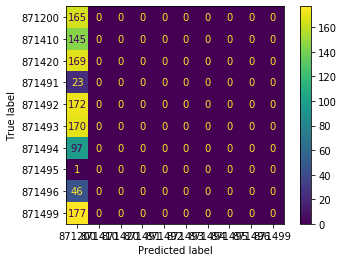

[[119   2   2   0   4   8   1   0   0   6]
 [  3 121   1   0   0   0   0   0   0   2]
 [  1   4 151   0   4   2   1   0   2   2]
 [  9   4   5  23   0   1   0   0   0  10]
 [  5   0   0   0 150   4   0   0   1   1]
 [  2   1   1   0  10 145   2   0   1   1]
 [ 13   3   1   0   0   3  91   0   0   4]
 [  3   2   0   0   2   0   0   1   0   7]
 [  3   2   3   0   0   2   0   0  41   4]
 [  7   6   5   0   2   5   2   0   1 140]]


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

trial1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB()),
])
 
acc = train(trial1, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['NB-BOW Desc','Accuracy'] = acc


Dev set results:
              precision    recall  f1-score   support

      871200       0.67      0.85      0.75       142
      871410       0.85      0.91      0.87       127
      871420       0.87      0.89      0.88       167
      871491       1.00      0.35      0.51        52
      871492       0.87      0.89      0.88       161
      871493       0.76      0.91      0.83       163
      871494       0.91      0.74      0.82       115
      871495       0.00      0.00      0.00        15
      871496       1.00      0.60      0.75        55
      871499       0.79      0.84      0.82       168

    accuracy                           0.82      1165
   macro avg       0.77      0.70      0.71      1165
weighted avg       0.82      0.82      0.81      1165



<Figure size 2160x2160 with 0 Axes>

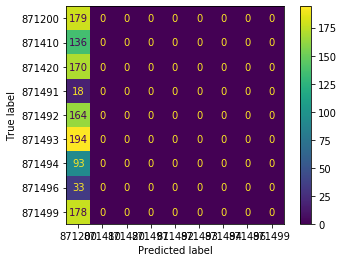

[[120   2   2   0   3   8   1   0   0   6]
 [  4 115   1   0   0   3   0   0   0   4]
 [  2   3 148   0   4   5   2   0   0   3]
 [ 13   4   7  18   0   3   0   0   0   7]
 [  6   1   0   0 143  11   0   0   0   0]
 [  4   0   1   0   7 148   3   0   0   0]
 [ 14   5   1   0   1   6  85   0   0   3]
 [  3   3   0   0   2   0   0   0   0   7]
 [  5   1   4   0   2   2   1   0  33   7]
 [  8   2   6   0   2   8   1   0   0 141]]


In [40]:
trial2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])
 
acc = train(trial2, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['NB-tfidf Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.75      0.73      0.74       142
      871410       0.82      0.86      0.84       127
      871420       0.85      0.91      0.88       167
      871491       0.69      0.46      0.55        52
      871492       0.84      0.92      0.88       161
      871493       0.89      0.82      0.85       163
      871494       0.69      0.92      0.79       115
      871495       0.75      0.20      0.32        15
      871496       0.90      0.69      0.78        55
      871499       0.86      0.78      0.82       168

    accuracy                           0.81      1165
   macro avg       0.80      0.73      0.74      1165
weighted avg       0.82      0.81      0.81      1165



<Figure size 2160x2160 with 0 Axes>

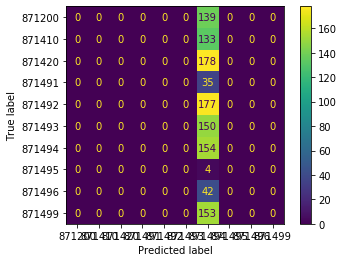

[[104   4   3   4   5   7  10   0   1   4]
 [  6 109   2   0   1   1   7   0   0   1]
 [  3   3 152   0   2   0   2   0   1   4]
 [  6   4   5  24   0   0   6   0   1   6]
 [  1   3   1   0 148   2   4   0   1   1]
 [  3   6   2   0  15 133   3   0   0   1]
 [  3   0   0   2   1   2 106   0   0   1]
 [  1   0   2   1   3   0   2   3   0   3]
 [  2   2   3   3   0   0   6   0  38   1]
 [ 10   2   8   1   2   5   8   1   0 131]]


In [41]:
trial3 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', KNeighborsClassifier()),
])
 
acc = train(trial3, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['NB-BOW Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.67      0.79      0.73       142
      871410       0.60      0.86      0.70       127
      871420       0.83      0.80      0.81       167
      871491       0.91      0.58      0.71        52
      871492       0.81      0.80      0.81       161
      871493       0.78      0.80      0.79       163
      871494       0.79      0.82      0.80       115
      871495       0.80      0.27      0.40        15
      871496       0.87      0.60      0.71        55
      871499       0.87      0.70      0.77       168

    accuracy                           0.77      1165
   macro avg       0.79      0.70      0.72      1165
weighted avg       0.78      0.77      0.77      1165



<Figure size 2160x2160 with 0 Axes>

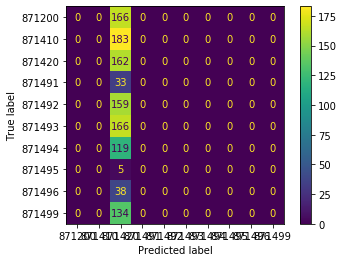

[[112  10   3   0   3   3   3   0   1   7]
 [  5 109   1   0   0   4   6   0   1   1]
 [  7   8 134   1   5   6   4   0   0   2]
 [ 10   5   2  30   0   2   1   0   0   2]
 [  2  13   4   1 129   9   0   0   0   3]
 [  4   6   4   1  13 130   3   1   1   0]
 [ 11   4   3   0   1   2  94   0   0   0]
 [  3   3   0   0   2   0   1   4   0   2]
 [  2  10   2   0   4   2   2   0  33   0]
 [ 10  15   9   0   2   8   5   0   2 117]]


In [42]:
trial4 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier()),
])
 
acc = train(trial4, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['KNN-BOW Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.75      0.73      0.74       142
      871410       0.82      0.86      0.84       127
      871420       0.85      0.91      0.88       167
      871491       0.69      0.46      0.55        52
      871492       0.84      0.92      0.88       161
      871493       0.89      0.82      0.85       163
      871494       0.69      0.92      0.79       115
      871495       0.75      0.20      0.32        15
      871496       0.90      0.69      0.78        55
      871499       0.86      0.78      0.82       168

    accuracy                           0.81      1165
   macro avg       0.80      0.73      0.74      1165
weighted avg       0.82      0.81      0.81      1165



<Figure size 2160x2160 with 0 Axes>

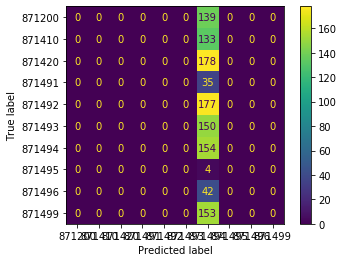

[[104   4   3   4   5   7  10   0   1   4]
 [  6 109   2   0   1   1   7   0   0   1]
 [  3   3 152   0   2   0   2   0   1   4]
 [  6   4   5  24   0   0   6   0   1   6]
 [  1   3   1   0 148   2   4   0   1   1]
 [  3   6   2   0  15 133   3   0   0   1]
 [  3   0   0   2   1   2 106   0   0   1]
 [  1   0   2   1   3   0   2   3   0   3]
 [  2   2   3   3   0   0   6   0  38   1]
 [ 10   2   8   1   2   5   8   1   0 131]]


In [43]:
trial5 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', KNeighborsClassifier()),
])
 
acc = train(trial5, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['KNN-tfidf Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.76      0.85      0.80       142
      871410       0.93      0.89      0.91       127
      871420       0.91      0.94      0.92       167
      871491       0.91      0.60      0.72        52
      871492       0.89      0.94      0.92       161
      871493       0.91      0.91      0.91       163
      871494       0.86      0.89      0.87       115
      871495       0.80      0.27      0.40        15
      871496       0.98      0.84      0.90        55
      871499       0.82      0.87      0.85       168

    accuracy                           0.87      1165
   macro avg       0.88      0.80      0.82      1165
weighted avg       0.88      0.87      0.87      1165



<Figure size 2160x2160 with 0 Axes>

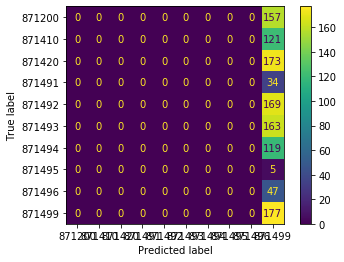

[[120   1   4   0   4   3   4   0   0   6]
 [  4 113   2   0   1   1   2   0   0   4]
 [  2   1 157   0   4   0   1   0   0   2]
 [  9   2   2  31   0   1   2   0   0   5]
 [  1   1   0   0 151   5   0   0   0   3]
 [  5   0   0   0   5 148   3   0   0   2]
 [  5   2   0   1   0   2 102   0   0   3]
 [  3   0   2   0   3   0   1   4   0   2]
 [  1   0   1   2   0   0   1   0  46   4]
 [  7   1   5   0   1   3   3   1   1 146]]


In [44]:
trial6 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier',LogisticRegression()),
])
 
acc = train(trial6, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['LogReg-BOW Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.75      0.85      0.80       142
      871410       0.92      0.93      0.93       127
      871420       0.87      0.93      0.90       167
      871491       1.00      0.58      0.73        52
      871492       0.88      0.94      0.91       161
      871493       0.88      0.89      0.89       163
      871494       0.89      0.86      0.88       115
      871495       1.00      0.13      0.24        15
      871496       0.94      0.84      0.88        55
      871499       0.83      0.85      0.84       168

    accuracy                           0.87      1165
   macro avg       0.90      0.78      0.80      1165
weighted avg       0.87      0.87      0.86      1165



<Figure size 2160x2160 with 0 Axes>

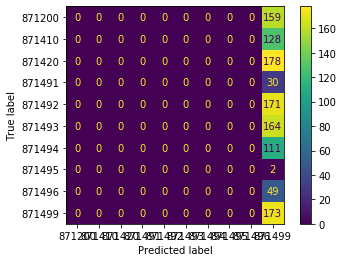

[[120   1   5   0   4   5   3   0   0   4]
 [  4 118   2   0   0   0   1   0   1   1]
 [  0   1 155   0   4   1   2   0   1   3]
 [ 10   3   2  30   0   0   1   0   0   6]
 [  1   1   0   0 151   5   0   0   0   3]
 [  5   0   0   0   9 145   2   0   0   2]
 [  8   2   1   0   0   2  99   0   0   3]
 [  3   1   2   0   2   0   0   2   0   5]
 [  2   0   2   0   0   1   1   0  46   3]
 [  6   1   9   0   1   5   2   0   1 143]]


In [45]:
trial7 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier',LogisticRegression()),
])
 
acc = train(trial7, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['LogReg-tfidf Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.79      0.86      0.82       142
      871410       0.87      0.92      0.90       127
      871420       0.92      0.92      0.92       167
      871491       0.96      0.52      0.67        52
      871492       0.90      0.94      0.92       161
      871493       0.93      0.90      0.92       163
      871494       0.90      0.94      0.92       115
      871495       1.00      0.27      0.42        15
      871496       1.00      0.78      0.88        55
      871499       0.77      0.87      0.82       168

    accuracy                           0.87      1165
   macro avg       0.90      0.79      0.82      1165
weighted avg       0.88      0.87      0.87      1165



<Figure size 2160x2160 with 0 Axes>

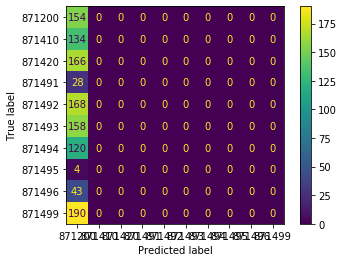

[[122   1   2   1   4   3   3   0   0   6]
 [  5 117   2   0   0   0   1   0   0   2]
 [  3   2 153   0   4   0   2   0   0   3]
 [  8   3   2  27   0   0   1   0   0  11]
 [  2   1   0   0 151   3   0   0   0   4]
 [  4   1   0   0   7 147   2   0   0   2]
 [  1   2   0   0   0   2 108   0   0   2]
 [  3   0   0   0   1   0   0   4   0   7]
 [  1   2   1   0   0   0   1   0  43   7]
 [  5   5   6   0   1   3   2   0   0 146]]


In [46]:
trial8 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC()),
])
 
acc = train(trial8, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['SVM-BOW Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.80      0.87      0.83       142
      871410       0.93      0.93      0.93       127
      871420       0.91      0.95      0.93       167
      871491       0.97      0.62      0.75        52
      871492       0.89      0.94      0.91       161
      871493       0.90      0.90      0.90       163
      871494       0.91      0.89      0.90       115
      871495       1.00      0.27      0.42        15
      871496       0.98      0.87      0.92        55
      871499       0.82      0.87      0.84       168

    accuracy                           0.88      1165
   macro avg       0.91      0.81      0.83      1165
weighted avg       0.89      0.88      0.88      1165



<Figure size 2160x2160 with 0 Axes>

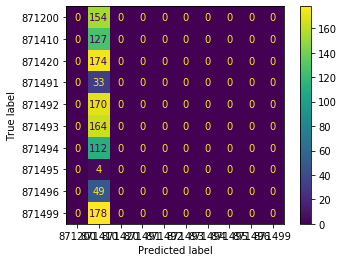

[[123   1   3   1   4   4   3   0   0   3]
 [  4 118   1   0   0   1   1   0   0   2]
 [  0   1 159   0   3   0   2   0   0   2]
 [  8   2   1  32   0   1   0   0   0   8]
 [  1   1   0   0 151   4   0   0   0   4]
 [  4   0   0   0   8 147   1   0   1   2]
 [  5   3   1   0   0   2 102   0   0   2]
 [  3   0   1   0   3   0   0   4   0   4]
 [  0   0   1   0   0   0   1   0  48   5]
 [  6   1   7   0   1   5   2   0   0 146]]


In [47]:
trial9 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC()),
])
 
acc = train(trial9, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['SVM-tfidf Desc','Accuracy'] = acc

[03:27:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Dev set results:
              precision    recall  f1-score   support

      871200       0.81      0.82      0.81       142
      871410       0.89      0.89      0.89       127
      871420       0.92      0.93      0.93       167
      871491       0.90      0.67      0.77        52
      871492       0.90      0.93      0.92       161
      871493       0.91      0.91      0.91       163
      871494       0.91      0.93      0.92       115
      871495       0.83      0.33      0.48        15
      871496       0.92      0.87      0.90        55
      871499       0.78      0.85      0.81       168

    accuracy                           0.88      1165
   macro avg       0.88      0.81      0.83      1165
weighted avg       0.88   

<Figure size 2160x2160 with 0 Axes>

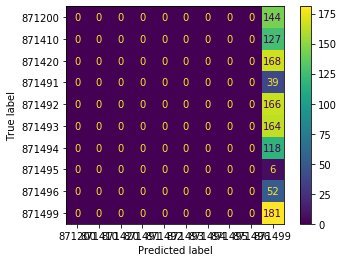

[[116   2   2   1   3   3   4   0   0  11]
 [  3 113   4   0   1   3   1   0   0   2]
 [  2   1 155   0   5   0   1   0   1   2]
 [  8   3   0  35   0   0   0   0   0   6]
 [  1   0   1   0 150   4   0   0   0   5]
 [  2   2   0   0   5 149   3   0   1   1]
 [  1   1   0   1   0   2 107   0   0   3]
 [  4   0   1   0   1   0   0   5   0   4]
 [  0   1   1   0   0   0   0   0  48   5]
 [  7   4   4   2   1   3   2   1   2 142]]


In [48]:
trial10 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', XGBClassifier()),
])
 
acc = train(trial10, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['XGBoost-BOW Desc','Accuracy'] = acc

In [ ]:
trial11 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier()),
])
 
acc = train(trial11, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['XGBoost-tfidf Desc','Accuracy'] = acc

[03:28:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [241]:
trial12 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier()),
])
 
acc = train(trial12, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['RF-BOW Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.87      0.85      0.86       142
      871410       0.88      0.96      0.92       127
      871420       0.89      0.95      0.92       167
      871491       0.95      0.77      0.85        52
      871492       0.90      0.93      0.91       161
      871493       0.90      0.90      0.90       163
      871494       0.89      0.93      0.91       115
      871495       1.00      0.47      0.64        15
      871496       0.98      0.85      0.91        55
      871499       0.91      0.88      0.89       168

    accuracy                           0.90      1165
   macro avg       0.92      0.85      0.87      1165
weighted avg       0.90      0.90      0.90      1165



In [242]:
trial13 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier()),
])
 
acc = train(trial13, X_train['Desc'], y_train, X_dev['Desc'], y_dev)

results.at['RF-tfidf Desc','Accuracy'] = acc

Dev set results:
              precision    recall  f1-score   support

      871200       0.86      0.87      0.86       142
      871410       0.89      0.95      0.92       127
      871420       0.86      0.93      0.90       167
      871491       0.93      0.73      0.82        52
      871492       0.90      0.93      0.92       161
      871493       0.92      0.91      0.92       163
      871494       0.91      0.92      0.92       115
      871495       0.80      0.27      0.40        15
      871496       0.98      0.84      0.90        55
      871499       0.88      0.88      0.88       168

    accuracy                           0.89      1165
   macro avg       0.89      0.82      0.84      1165
weighted avg       0.89      0.89      0.89      1165



In [243]:
results

,Accuracy
Baseline,0.141048
NB-BOW Desc,0.816309
NB-tfidf Desc,0.828326
KNN-BOW Desc,0.804292
KNN-tfidf Desc,0.816309
LogReg-BOW Desc,0.880687
LogReg-tfidf Desc,0.87382
SVM-BOW Desc,0.883262
SVM-tfidf Desc,0.893562
XGBoost-BOW Desc,0.892704


[Text(0, 0, 'Baseline'),
 Text(0, 0, 'NB-BOW Desc'),
 Text(0, 0, 'NB-tfidf Desc'),
 Text(0, 0, 'KNN-BOW Desc'),
 Text(0, 0, 'KNN-tfidf Desc'),
 Text(0, 0, 'LogReg-BOW Desc'),
 Text(0, 0, 'LogReg-tfidf Desc'),
 Text(0, 0, 'SVM-BOW Desc'),
 Text(0, 0, 'SVM-tfidf Desc'),
 Text(0, 0, 'XGBoost-BOW Desc'),
 Text(0, 0, 'XGBoost-tfidf Desc'),
 Text(0, 0, 'RF-BOW Desc'),
 Text(0, 0, 'RF-tfidf Desc')]

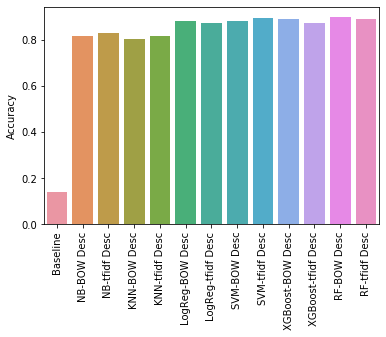

In [244]:
ax = sns.barplot(x=results.index, y=results["Accuracy"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## Work with the BERT embeddings

In [73]:
models = {
    'knn' : KNeighborsClassifier(), 'logit' : LogisticRegression(), 'svm': SVC()
}

for model, call in models.items():
    print(f'Training {model}')
    call.fit(X_train['BERT_Product Desc'], y_train)
    pred = call.predict(X_dev['BERT_Product Desc'], y_dev)
    print(accuracy_score(y_dev, pred))
    print()

Training knn


ValueError: setting an array element with a sequence.